Kalman Filter Illustrative Code
===================================
This is a companion notebook illustrating the Kalman Filter models discussed in our review series. The easiest way to run or edit this notebook to visit the latest [Kaggle version](https://www.kaggle.com/baogorek/kalman-filter-illustrative-code), but you may also host it yourself (see [README.md](./README.md)).

## Dependencies
 - [example_loads.csv](https://www.kaggle.com/baogorek/example-training-loads), a data set of example training loads created by @bsh2020.
 - [kalmanfilterfunctions.R](https://www.kaggle.com/baogorek/kalmanfilterfunctions), an R script containing functions relevant to the Fitness Fatigue model and variations discussed in our review papers
 - [ffmfunctions.R](https://www.kaggle.com/baogorek/ffmfunctions), an R script containing functions relevant to the Fitness Fatigue model and variations discussed in our review papers

In [1]:
source("kalmanfilterfunctions.R")
example_loads <- read.csv("example_loads.csv")

set.seed(1443)

[1] "Version 15"


## Training loads

In this research, the raw training loads $\omega^i$ are taken to be exogenous, i.e., coming from some predetermined plan, not a downstream impact of actual performance. It is represented in the code as `w`.

As noted in the dependencies, this notebook is accompied by an extensive training load dataset, which uses real exercises and separates upper body from lower body training impulses. These may be used below by choosing `training_type` to be either `"upper body"` or `"lower body"`. In addition there is also a fully synthetic option, `"synthetic"` that creates variation oportunistically, such as a long rest in the middle of the program so that fitness has time to fade. 


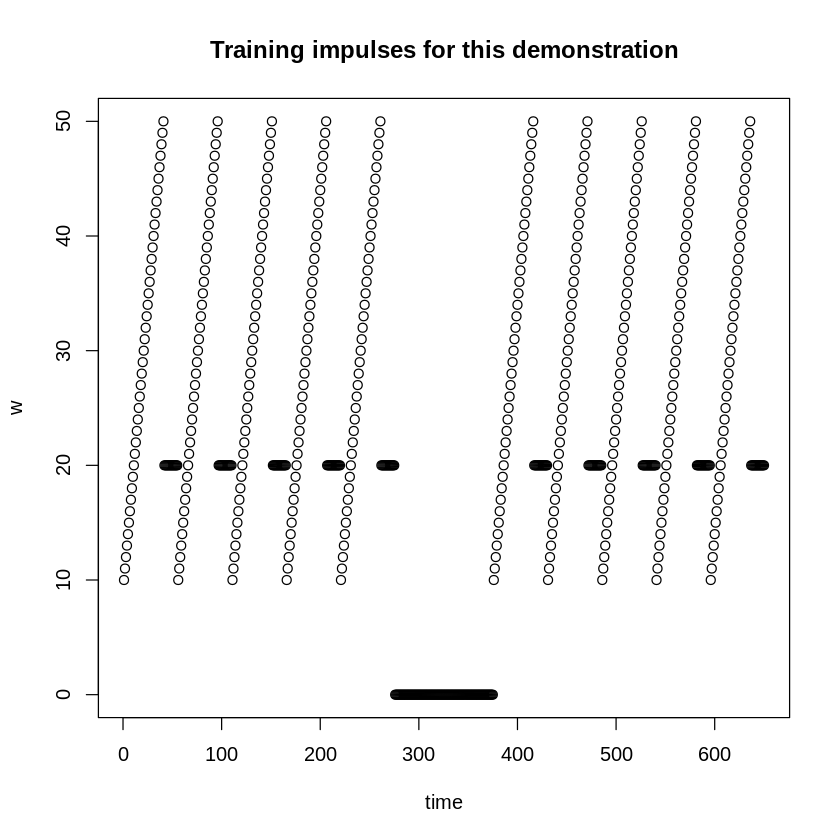

In [2]:
# The Training Plan -----------------------------------------------------------

# "upper body", "lower body", "synthetic"
training_type <- "synthetic" 

if (training_type == "synthetic") {
  w <- rep(c(seq(10, 50), rep(20, 14)), 5)
  w <- c(w, rep(0, 100), w)  #  Adding long rest!
} else if (training_type == "upper body") {
  w <- as.numeric(example_loads$tl_upper_fitness)
} else if (training_type == "lower body") {
  w <- as.numeric(example_loads$tl_lower_fitness)
}

plot(w, main = "Training impulses for this demonstration", xlab = "time")

## The Kalman Filter Representation of the Fitness-Fatigue Model

The fitness-fatigue model can be put into state space form:

$$
\begin{align}
\mathbf{x}_{n + 1} &= \mathbf{A}_n \mathbf{x}_n + \mathbf{B}_n \omega_n + \mathbf{v}_n, \\
p_n &= p^{\star} + \mathbf{C}_n \mathbf{x}_n + \mathbf{\eta}_n,
\end{align}
$$

where the state vector is comprised of fitness and fatigue at time $n$, respectively:

$$
\mathbf{x}_{n} = \left(\begin{matrix} g(n)  \\ h(n) \end{matrix} \right).
$$

The state and observation error terms are distributed i.i.d as

$$\mathbf{v}_n \sim N(\mathbf{0}, \mathbf{Q}_n) \text{  and  } \eta_n \sim N(0, \xi^2).$$

To align with the fitness-fatigue model, the matrices are all time-invariant:

$$
\mathbf{A}_{n} = \mathbf{A} =  \left(\begin{matrix} e ^ {-\frac{1}{\tau_g}} & 0  \\ 0 & e ^ {-\frac{1}{\tau_h}} \end{matrix} \right),
\mathbf{B}_{n} = \mathbf{B} = \left(\begin{matrix} e ^ {-\frac{1}{\tau_g}} \\ e ^ {-\frac{1}{\tau_h}} \end{matrix} \right),
\mathbf{Q}_{n} = \mathbf{Q} =  \left(\begin{matrix} \sigma_g ^ 2 & \sigma_{g, h}  \\ \sigma_{g, h} & \sigma_h ^ 2\end{matrix} \right).
$$

Note that in the variance matrix $\mathbf{Q}$, the covariance $\sigma_{g, h}$ can be rewritten as $\sigma_g \sigma_h \rho$, where $\rho$ is the correlation between the state error term elements.

For initialization,

$$
\mathbf{x}_{0} = \left(\begin{matrix} g(0)  \\ h(0) \end{matrix} \right)
$$

is treated as an unknown vector parameter, $\omega_0$ is set to $\bar{\omega}$ and the matrix
$\mathbf{M}_{0} = \text{Var}(\mathbf{x}_{0})$ is typically set to have large values on the diagonal to represent the uncertainty in the initial value.

Below we instantiate a Kalman Filter model in code. Note that $\omega$ is called `w` in code.

In [3]:
kalman_model <- create_kalman_model(p_star = 400, k_g = .1, k_h = .3, tau_g = 50,
                                    tau_h = 15, xi = 15,
                                    sigma_g = 20, sigma_h = 10, rho_gh = .2,
                                    initial_g = 250, initial_h = 100,
                                    initial_sd_g = 500, initial_sd_h = 250,
                                    initial_rho_gh = 0)
print(kalman_model)


------- Your Kalman Filter Model -----
------- State Model ------------------
        A                              B                        
x_n = [ 0.9802 0.0000 ] *  x_{n-1} + [ 0.9802 ] * w_{n-1} + v_n 
        0.0000 0.9355                  0.9355                   
with state error
              Q         
v_n ~ N( 0 ,  400  40 ) 
         0     40 100   

The filter is initialized by: 
                           M_0             
x_0 =[ 250 ], Var(x_0) = [ 250000      0 ] 
       100                      0  62500   

------- Measurement Model ------------
              C                         
p_n = 400 + [  0.1 -0.3 ] * x_n + eta_n 

where
                xi      
eta_n ~ N( 0 ,  15 ^ 2) 


In [4]:
df <- simulate(kalman_model, w)
head(df)

,t,w,p,g,h
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,10,419.0723,250.0000,100.0000
2,2,11,381.8214,264.0411,129.5445
3,3,12,394.2507,284.9983,146.6685
4,4,13,370.1700,312.6814,159.2253
5,5,14,381.0711,326.3611,169.9618
6,6,15,375.3509,345.9119,201.2673


## Filtered Values
At each time step $n$, the fitness and fatigue estimates are updated for all observations up to and including $p_n$. The `filter` function returns a list with the following elements:
- `p_hat`, a vector of fitted values based on the filtered fitness and fatigue estimates
- `X` an nx2 matrix of a posteriori fitness and fatigue  estimates
- `M` an nx4 matrix of vectorized esimtation covariance matrices
- `Z` an nx2 matrix of a priori fitness and fatigue state estimates
- `loglike` the loglikelihood of the sequence


We will first filter using a Kalman Filter with all parameters set to the truth. Even in this case, the state is still latent and needs to be estimated.

In [5]:
# get aquinted with the data structure produced by filter()
filtered <- filter(kalman_model, df)
names(filtered)

[1] "p_hat"   "g_hat"   "h_hat"   "M"       "Z"       "loglike"

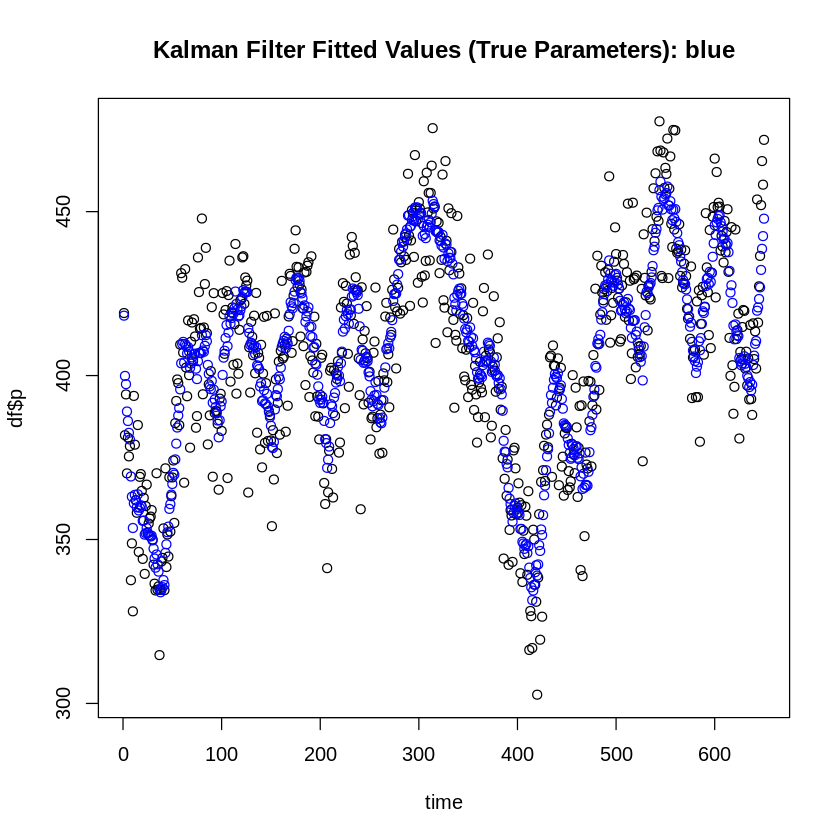

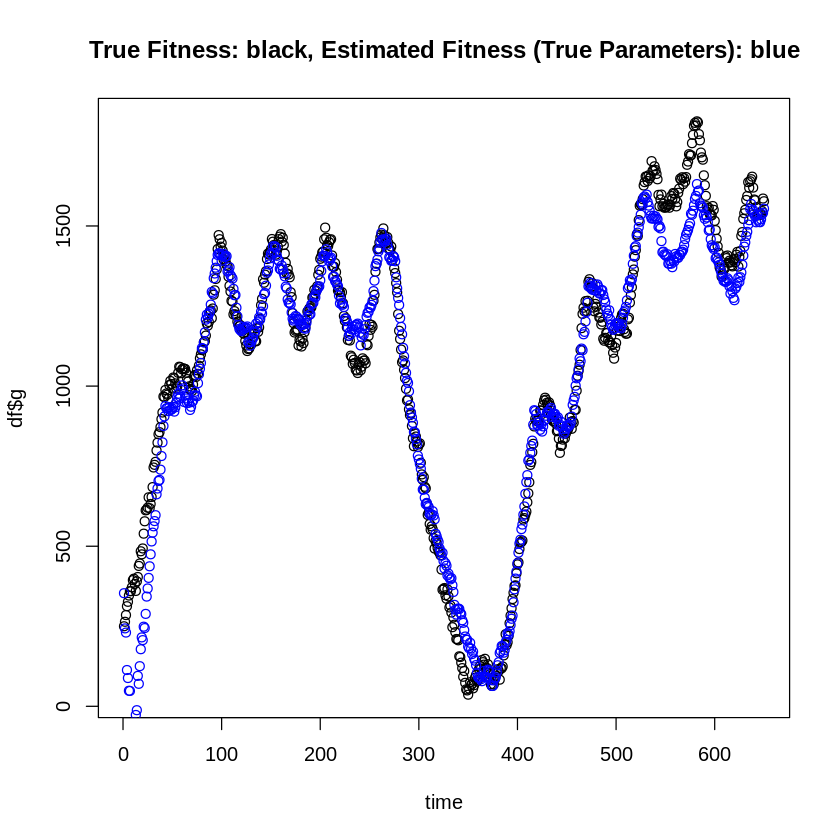

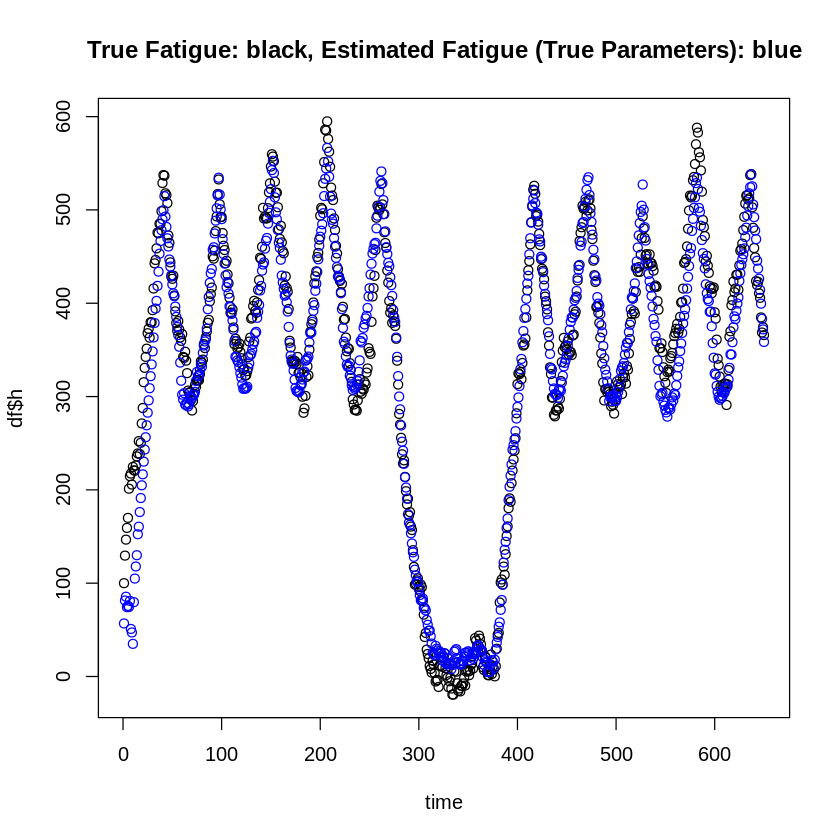

In [6]:
# Predictions with True Parameters
plot(df$p, xlab = "time",
     main = "Kalman Filter Fitted Values (True Parameters): blue")
points(filtered$p_hat, col = 'blue')

plot(df$g, xlab = "time",
     main = "True Fitness: black, Estimated Fitness (True Parameters): blue")
points(filtered$g_hat, col = 'blue')

plot(df$h, xlab = "time",
     main = "True Fatigue: black, Estimated Fatigue (True Parameters): blue")
points(filtered$h_hat, col = 'blue')

## Maximum Likelihood Estimation
As suggested by the filter function's output, the likelihood of a performance trajectory is easily computed within the filtering flow, making maximum likelihood estimation a convenient choice. We start by intializing a Kalman Filter from the data set to obtain reasonable starting values. Then we apply the L-BFGS-B algorithm to maximize the likelihood from these initial conditions.

In [7]:
kf_from_data <- initialize_kalman_from_data(df)
print(kf_from_data)


------- Your Kalman Filter Model -----
------- State Model ------------------
        A                              B                        
x_n = [ 0.9672 0.0000 ] *  x_{n-1} + [ 0.9672 ] * w_{n-1} + v_n 
        0.0000 0.9355                  0.9355                   
with state error
              Q                   
v_n ~ N( 0 ,  189.9959   0.0000 ) 
         0      0.0000 177.7425   

The filter is initialized by: 
                                M_0                   
x_0 =[ 640.8831 ], Var(x_0) = [ 102682.79      0.00 ] 
       310.0557                      0.00  24033.63   

------- Measurement Model ------------
                   C                               
p_n = 389.5207 + [  0.2788 -0.5012 ] * x_n + eta_n 

where
                xi           
eta_n ~ N( 0 ,  19.7447 ^ 2) 


In [8]:
# Use machine-precision (factr = 1), do the best you can do!
kf_ml <- maximize_likelihood(kf_from_data, df, factr = 1)
print(kf_ml)


Starting L-BFGS-B optimization with factr 1 

Starting -log likelihood is 2818.059 
Minimizing. This might take a few minutes...

L-BFGS-B procedure finished with message:
 CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH 

The final value of -log likelihood is 2743.861 

------- Your Kalman Filter Model -----
------- State Model ------------------
        A                              B                        
x_n = [ 0.9838 0.0000 ] *  x_{n-1} + [ 0.9838 ] * w_{n-1} + v_n 
        0.0000 0.9282                  0.9282                   
with state error
              Q                   
v_n ~ N( 0 ,  584.3744   0.1372 ) 
         0      0.1372   2.9285   

The filter is initialized by: 
                                M_0                   
x_0 =[ 640.8831 ], Var(x_0) = [ 102682.79      0.00 ] 
       310.0557                      0.00  24033.63   

------- Measurement Model ------------
                   C                               
p_n = 366.0753 + [  0.0983 -0.2927 ] * x_n 

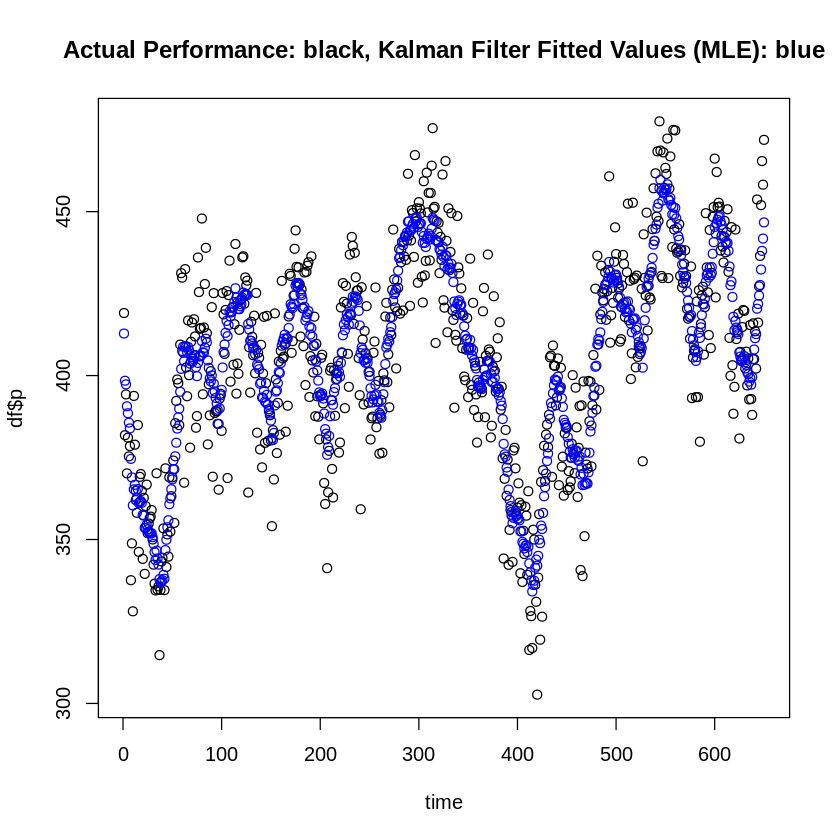

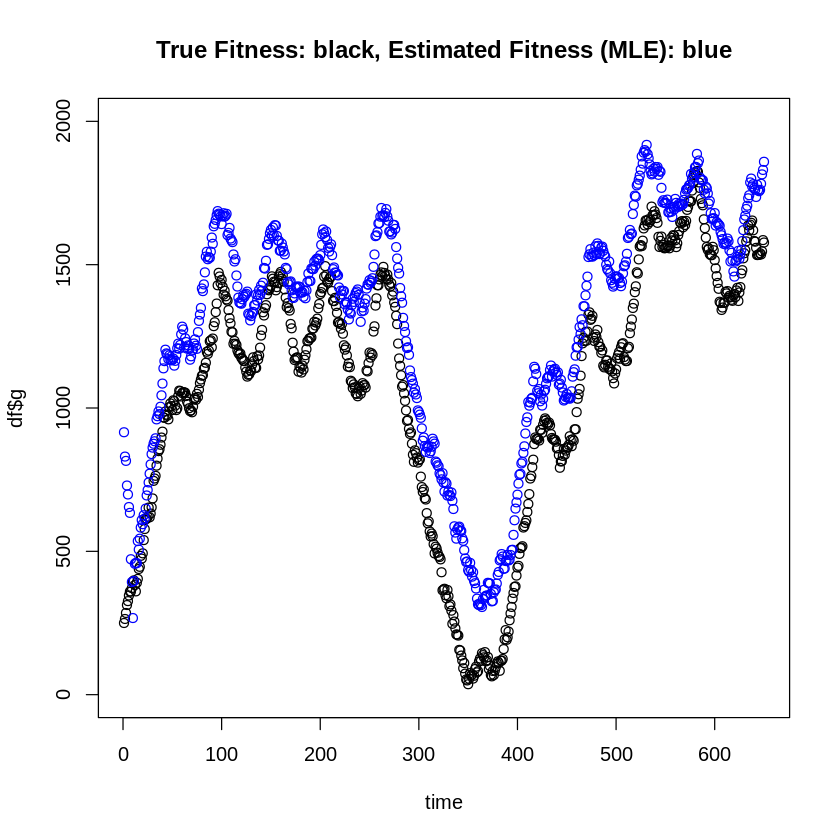

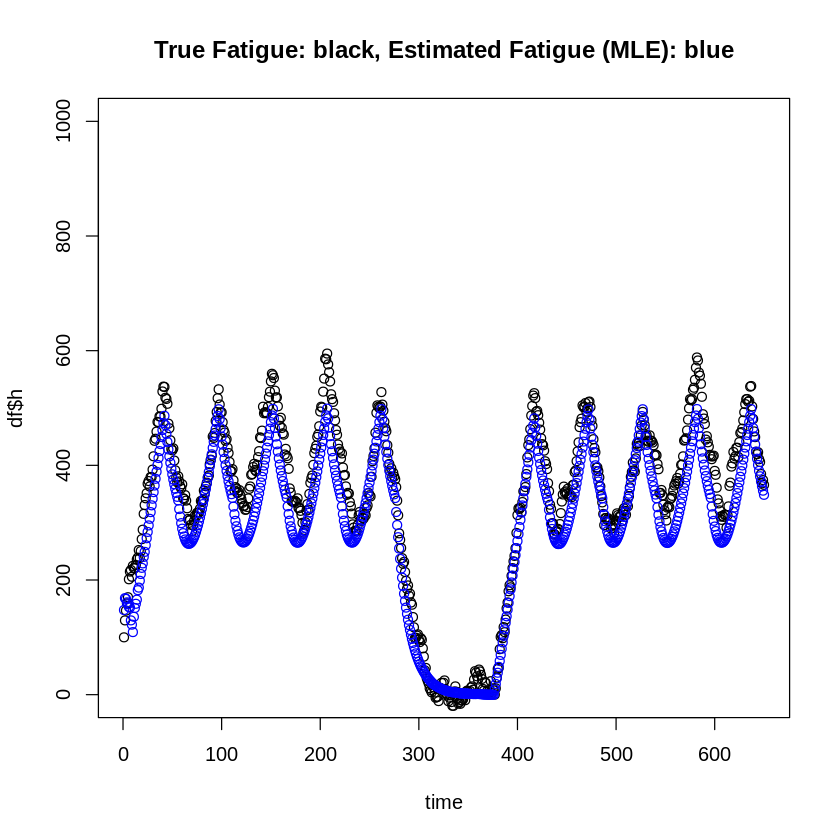

In [9]:
filtered_ml <- filter(kf_ml, df)

# Predictions with Estimated Parameters
plot(df$p, xlab = "time",
     main = "Actual Performance: black, Kalman Filter Fitted Values (MLE): blue")
points(filtered_ml$p_hat, col = 'blue')

plot(df$g, xlab = "time",
     main = "True Fitness: black, Estimated Fitness (MLE): blue",
     ylim = c(0, 2000))
points(filtered_ml$g_hat, col = 'blue')

plot(df$h, xlab = "time",
     main = "True Fatigue: black, Estimated Fatigue (MLE): blue",
     ylim = c(0, 1000))
points(filtered_ml$h_hat, col = 'blue')

## Demonstration of Kalman Filter Updating

### A priori to a posteriori and performance residuals

One way to see the Kalman Filter in action is to view the update from *a priori* to *a posteriori* as a function. The *a priori* state estimate $\mathbf{z}_n$ is a deterministic update from the previous estimated (*a posteriori*) state value:

$$
\mathbf{z}_n = \mathbf{A} \hat{\mathbf{x}}_{n - 1} + \mathbf{B} \omega_{n - 1}
$$

In this section we use the true parameter values for the filtering illustrate the property most clearly. The plot of *a priori* residuals is shown underneath the plot of *a priori* to *a posteriori* filtered estimates of fitness and aligned to the time index. What can be observed is that larger positive *a priori* residuals correspond to larger positive movements from *a priori* to *a posteriori* fitness. The Kalman Filter is thus "fusing" the observed performance measurement with the predictions from the fitness-fatigue differential equation to arrive at a compromise between the two.

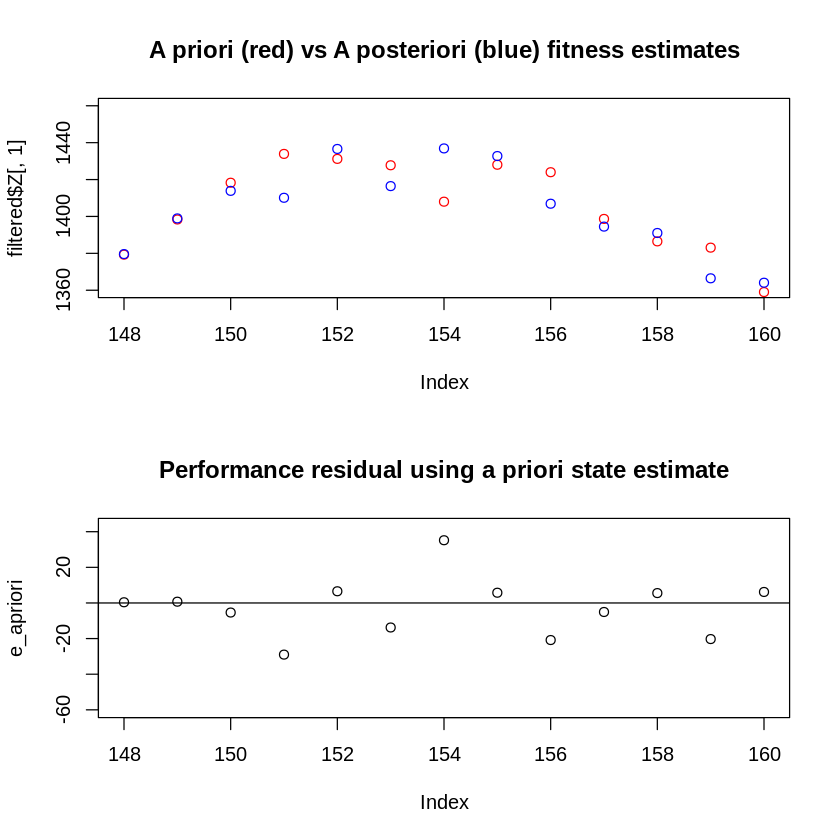

In [10]:
p_hat_apriori <- as.numeric(kalman_model$p_star + kalman_model$C %*% t(filtered$Z))
e_apriori <- df$p - p_hat_apriori

par(mfrow = c(2, 1))
plot(filtered$Z[, 1],  xlim = c(148, 160), ylim = c(1360, 1460),
     col = "red",  main = "A priori (red) vs A posteriori (blue) fitness estimates")
points(filtered$g_hat, col = "blue")
plot(e_apriori, xlim = c(148, 160),
     main = "Performance residual using a priori state estimate")
abline(h = 0)

### Basic (5 parameter) Fitness-Fatigue Model vs Kalman Filter

The fitness-fatigue model makes predictions solely as a function of the past training impulses, whereas the Kalman Filter updates the state estimate at each iteration. We'll see how this plays out in this section.



In [11]:
source("./ffmfunctions.R")

[1] "Version 16"


In [12]:
ffm_from_data <- initialize_ffm_from_data(df)
ffm_ml <- maximize_likelihood(ffm_from_data, df)
ffm_pred_df <- make_predictions(ffm_ml, w)

The best combination------
   tau_g tau_h tau_h2 delta gamma   p_star       k_g       k_h    sigma
15    30    15     NA    NA    NA 389.5207 0.2788477 0.5012007 19.74474
   fitness_0 fatigue_0
15         0         0

Starting L-BFGS-B optimization via optim.
Depending on the model, this could take a few minutes...
Factor of machine tolerance for relative convergence: 10 


While fitness and fatigue estimates are somewhat different between the basic model and the Kalman Filter, note that the differences largely cancel out in the predicted values. There is a more marked difference near the end where the Kalman Filter has a trending fitness estimate that differs from the fitness-fatigue model. This results in higher performance predictions that do indeed match the data better.

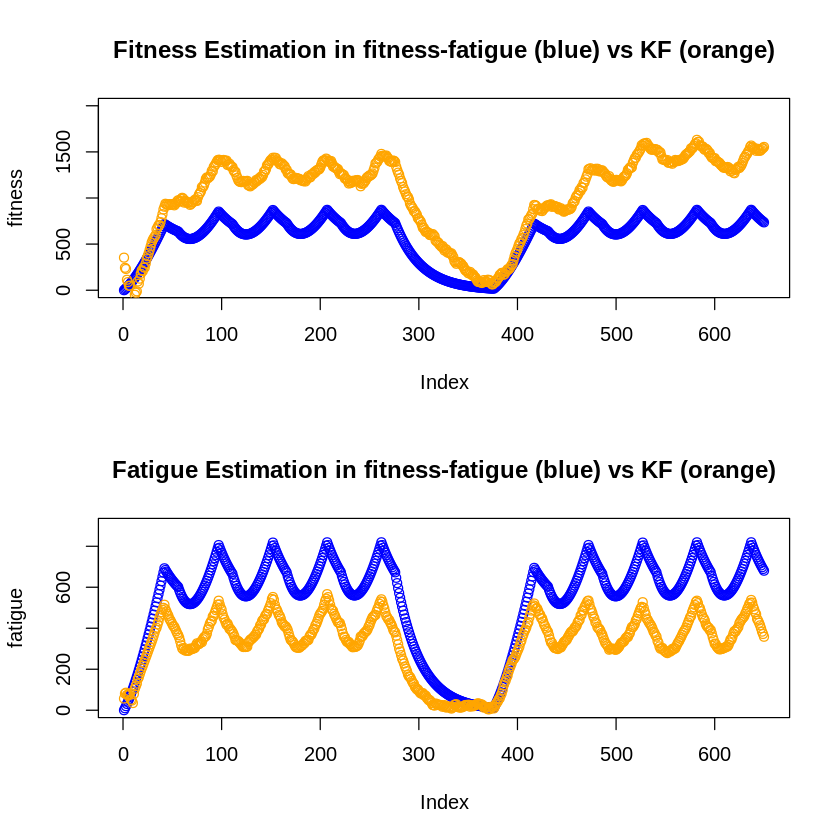

In [13]:
par(mfrow=c(2, 1))

plot(ffm_pred_df$g_hat, ylim = c(0, 2000), col = "blue", ylab = "fitness",
     main = "Fitness Estimation in fitness-fatigue (blue) vs KF (orange)")
points(filtered$g_hat, col = 'orange')

plot(ffm_pred_df$h_hat, ylim = c(0, 900), col = "blue", ylab = "fatigue",
     main = "Fatigue Estimation in fitness-fatigue (blue) vs KF (orange)")
points(filtered$h_hat, col = 'orange')

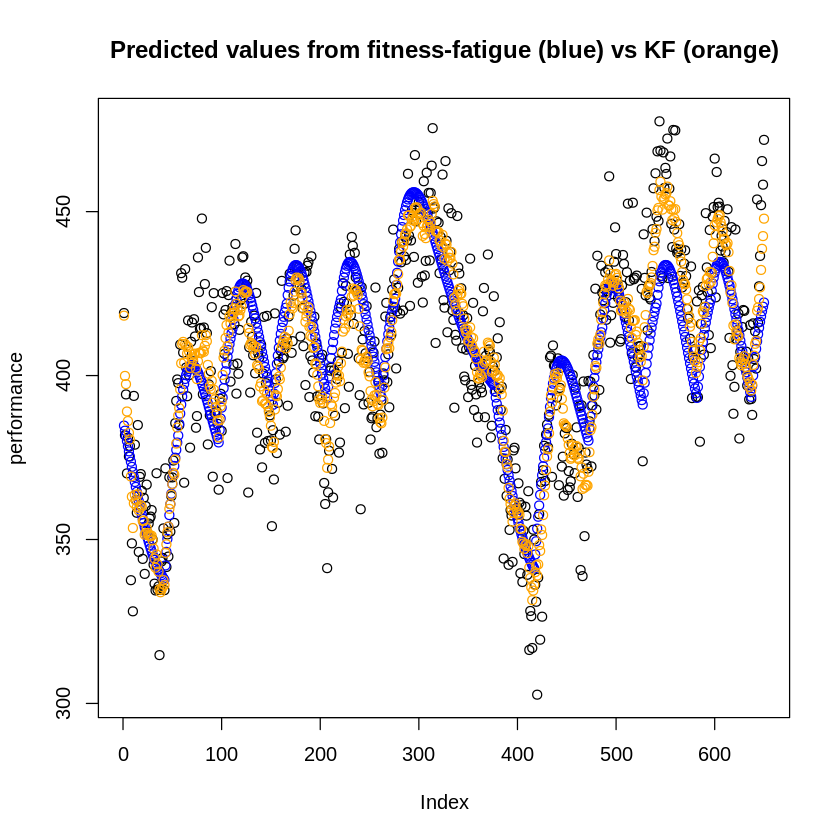

In [14]:
plot(df$p, main = "Predicted values from fitness-fatigue (blue) vs KF (orange)",
     ylab = "performance")
points(ffm_pred_df$p_hat, col = "blue")
points(filtered$p_hat, col = "orange")

If we zoom in on a subsection, we can we that the Kalman Filter (in orange) is reacting to the actual observed performance values, whereas the fitness-fatigue model only considers the exponentially-weighted average of training inputs. Thus, the latter is smoother whereas the former is more reactive to the actual data as it comes in.

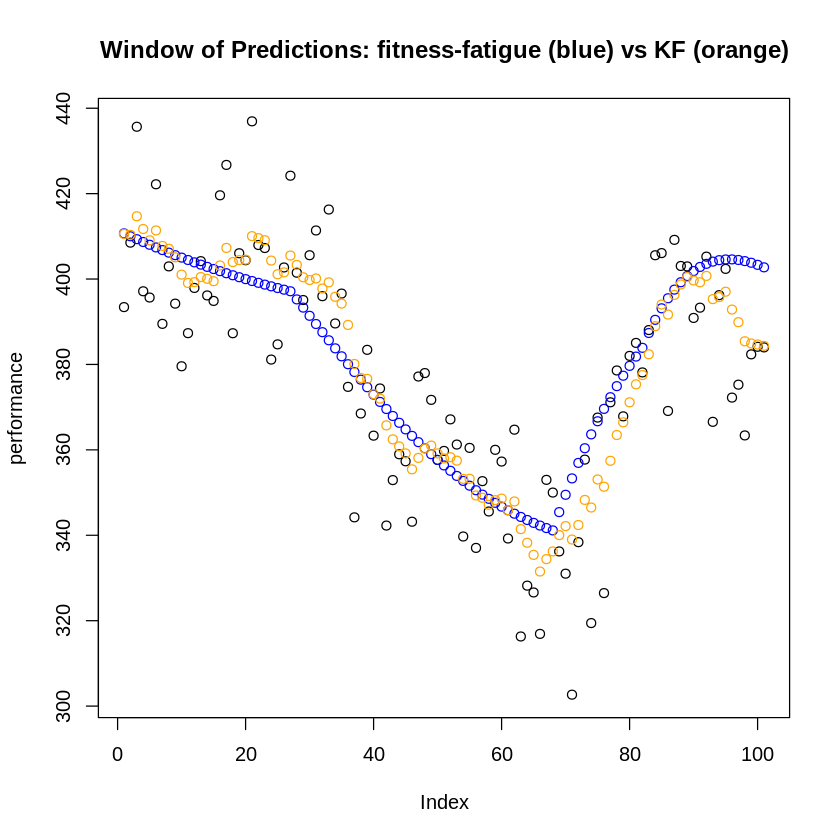

In [15]:
i <- 350
j <- 450
plot(df$p[i:j], main = "Window of Predictions: fitness-fatigue (blue) vs KF (orange)",
     ylab = "performance")
points(ffm_pred_df$p_hat[i:j], col = "blue")
points(filtered$p_hat[i:j], col = "orange")